# Imports

In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import os 
funcs = os.listdir('functions')

for func in funcs:
    if func.startswith('__') or func == 'import_all_functions.py':
        continue
    func = func.replace('.py','')
    print(f'{func} imported')
    exec(f'from functions.{func} import *')

import_to_df imported
impute_cond_mean imported
get_kaggle_data imported
test imported
process_data imported


In [97]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as pyplot
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [84]:
files = get_kaggle_data(competition="titanic")

files downloaded for titanic competition
   test.csv
   train.csv
   gender_submission.csv
located in /competition_data/


In [85]:
input_data = import_to_df(files)

In [86]:
train = input_data['train'].copy()
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [74]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

Missing values in Age column

In [75]:
display(len(train[train['Age'].isna()]))
display(len(train[train['Age'].isna()]) / len(train))

177

0.19865319865319866

Nearly 20% of ages missing. Lets impute those using the mean of Pclass as gender

In [76]:
train_df = impute_cond_mean(
    df=train,
    col_with_na='Age',
    cond_cols=['Pclass', 'Sex']
)

In [77]:
train_df.head()

PassengerId  Survived  Pclass                            Name   Sex  \
0            1         0       3         Braund, Mr. Owen Harris  male   
1            5         0       3        Allen, Mr. William Henry  male   
2            6         0       3                Moran, Mr. James  male   
3            8         0       3  Palsson, Master. Gosta Leonard  male   
4           13         0       3  Saundercock, Mr. William Henry  male   

         Age  SibSp  Parch     Ticket     Fare Cabin Embarked  
0  22.000000      1      0  A/5 21171   7.2500   NaN        S  
1  35.000000      0      0     373450   8.0500   NaN        S  
2  26.507589      0      0     330877   8.4583   NaN        Q  
3   2.000000      3      1     349909  21.0750   NaN        S  
4  20.000000      0      0  A/5. 2151   8.0500   NaN        S

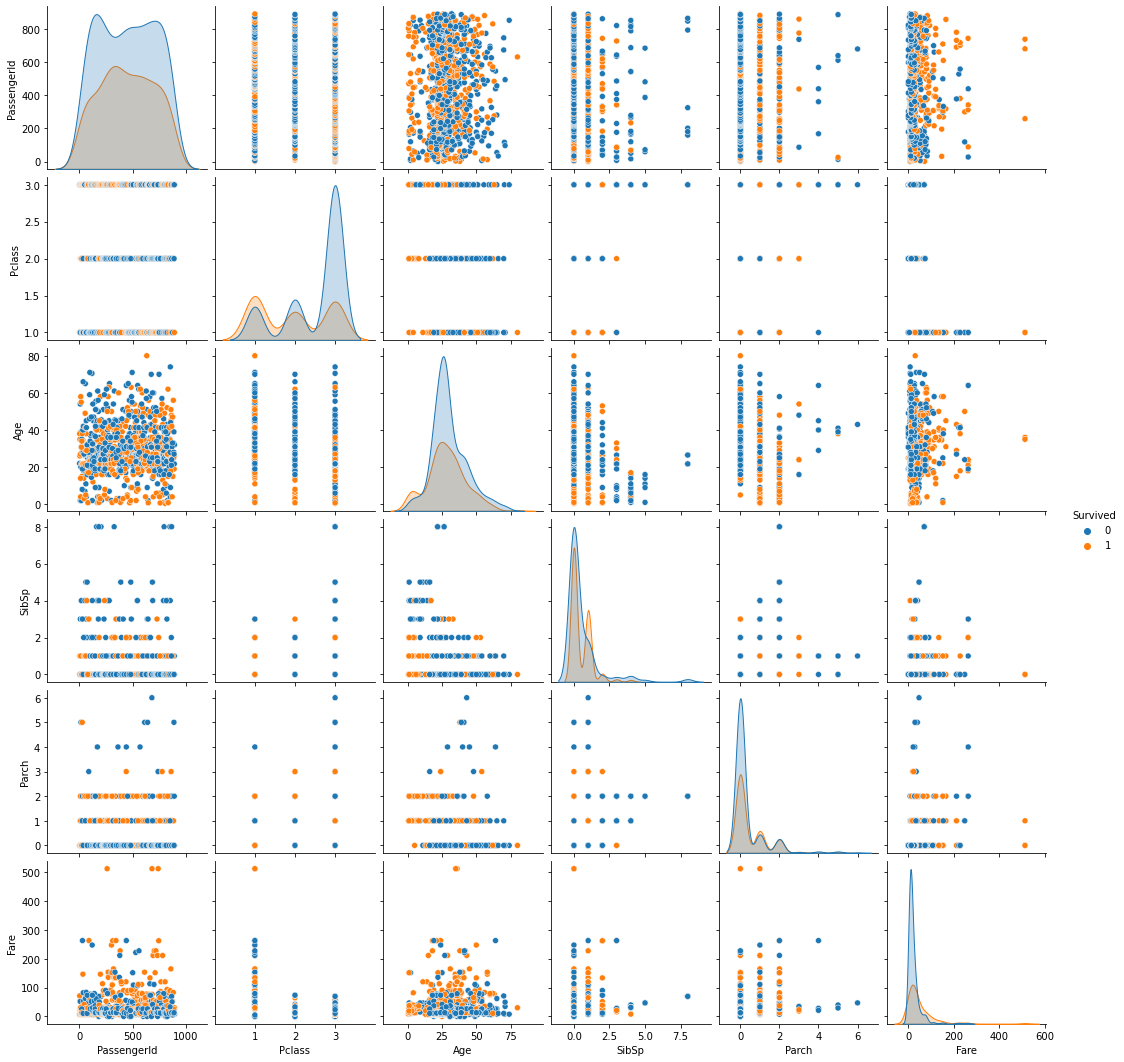

In [78]:
sns.pairplot(train_df, hue='Survived')

Pclass seems to be strong predictor of survival with class 3 having a huge number of deaths


In [79]:
remove_cols = ['PassengerId', 'Name', 'Ticket']
dummy_cols = ['Sex', 'Embarked']



In [81]:
processed_df = train_df.drop(columns=remove_cols)
processed_df = pd.get_dummies(processed_df, columns=dummy_cols)
processed_df.head()

Survived  Pclass        Age  SibSp  Parch     Fare Cabin  Sex_female  \
0         0       3  22.000000      1      0   7.2500   NaN           0   
1         0       3  35.000000      0      0   8.0500   NaN           0   
2         0       3  26.507589      0      0   8.4583   NaN           0   
3         0       3   2.000000      3      1  21.0750   NaN           0   
4         0       3  20.000000      0      0   8.0500   NaN           0   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0         1           0           0           1  
1         1           0           0           1  
2         1           0           1           0  
3         1           0           0           1  
4         1           0           0           1

In [114]:
processed_data = {}
processed_data['train'] = process_data(input_data['train'])
processed_data['test'] = process_data(input_data['test'])

X_cols = [ 
    col for 
    col in processed_data['train']
    if col != 'Survived'
]

X_train = processed_data['train'][X_cols]
y_train = processed_data['train']

In [115]:
# prepare the cross-validation procedure
cv = KFold(n_splits=4, random_state=1, shuffle=True)
# create model
model = LogisticRegression()
# evaluate model
scores = cross_val_score(model, X_train.values, y_train, cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: nan (nan)


In [118]:
X_train['Cabin'].value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
D              3
E101           3
              ..
A19            1
D50            1
E34            1
A6             1
C47            1
Name: Cabin, Length: 147, dtype: int64

In [102]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)

In [104]:
X

array([[  2.47475454,   0.40165523,   1.68081787, ...,  -6.59044146,
         -2.21290585,  -3.139579  ],
       [  0.84802507,   2.81841945,  -2.76008732, ...,   3.00844461,
          0.78661954,  -1.27681551],
       [ -1.90041246,  -0.56901823,  -1.76220236, ...,   3.37336417,
         -2.28613707,   1.90344983],
       ...,
       [  0.7673844 ,  -2.91920559,   2.80851577, ...,   4.42591832,
          0.46321196,  -3.30523346],
       [  2.05510667,  -0.99009741,   0.73577291, ...,   3.05100898,
         -1.40715279,  -0.51579331],
       [-10.96847792,  -2.39810735,  -0.96700953, ..., -11.16298557,
          1.16646392,   0.60835176]])